### Linear Regression of Airbnb Room Data

In [1]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np
from sklearn_pandas import DataFrameMapper
# import statsmodels.formula.api as smf
import pandas as pd

In [2]:
def print_scores(model, xtrain, ytrain, xtest, ytest):
    """Prints scores for a model with training, and test data splits."""
    print('Train R2', round(model.score(xtrain, ytrain), 3))
    print('Test R2', round(model.score(xtest, ytest), 3))
    return None

In [3]:
def print_root_mean_err(true, pred):
    print('RMSError = ${}'.format(round(np.sqrt(mean_squared_error(true, pred)), 2)))
    return None

In [4]:
# Read in room data
# rooms = pd.read_csv('../data/bogota-clean-10-06-2019--20-16-39.csv')
# rooms['cleaning_fee'] = replace_zeroes(rooms.cleaning_fee)
# rooms['beds'] = replace_zeroes(rooms.beds)

In [5]:
# Read in room data
rooms = pd.read_csv('../data/tokyo-clean-10-09-2019--12-31-16.csv')

In [6]:
rooms.shape

(1804, 12)

In [7]:
# Set target variable and features array. The target is the price of the room.
y = rooms.price
X = rooms[['guests', 'bedrooms', 'beds', 'baths', 'cleaning_fee',
           'amenities', 'superhost', 'narrative', 'rules']]
# X = rooms[['guests', 'bedrooms', 'baths', 'cleaning_fee',
#            'amenities', 'superhost', 'narrative', 'rules']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
y_rmse = y_test.copy()

In [8]:
# Fit training data and attempt to predict test data.
lr = LinearRegression(n_jobs=10, copy_X=True)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

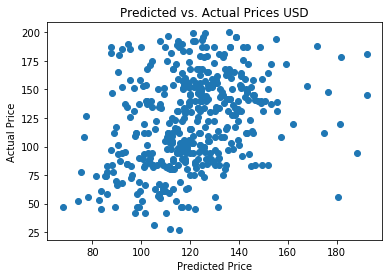

In [9]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_predict, y_test);

Residuals are y_test - y_predict

Display the $R^2\; score$ for the predicted values.

In [10]:
# r^2 scores
print_scores(lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_rmse, y_predict)

Train R2 0.198
Test R2 0.085
RMSError = $38.13


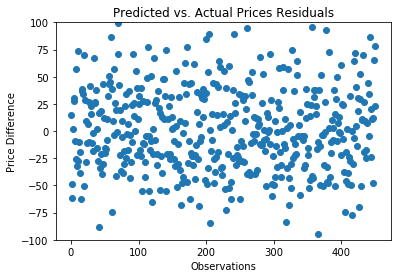

In [11]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.scatter(x_vals, y_test - y_predict)
plt.ylim(-100, 100)
plt.title('Predicted vs. Actual Prices Residuals')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Since Linear Regression didn't perform that great we will try applying some transforms

In [12]:
# Rerun the regression with transforms
pipe = make_pipeline(StandardScaler(), LinearRegression(copy_X=True))
pipe.fit(X_train, y_train)
y_scaled_predict = pipe.predict(X_test)
# pipe.fit_transform()

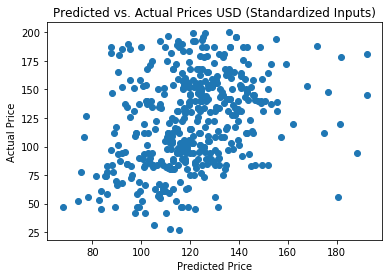

In [13]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD (Standardized Inputs)')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_scaled_predict, y_test);

In [14]:
print_scores(pipe, X_train, y_train, X_test, y_test)
print_root_mean_err(y_rmse, y_scaled_predict)

Train R2 0.198
Test R2 0.085
RMSError = $38.13


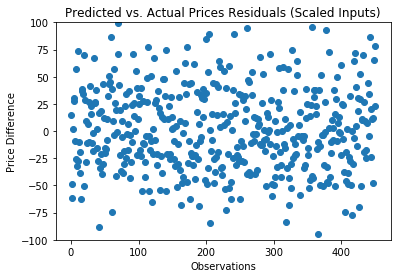

In [15]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.scatter(x_vals, y_test - y_scaled_predict)
plt.ylim(-100, 100)
plt.title('Predicted vs. Actual Prices Residuals (Scaled Inputs)')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Try taking the log of several features to see if that improves performance of the model. Need to improve upon $RMSError = \$59.89$

In [16]:
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'bedrooms', 'cleaning_fee'], log_and_std),
    (['baths', 'beds', 'amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_rmse, mapped_lr.predict(X_test))

Train R2 0.162
Test R2 0.087
RMSError = $38.11


In [17]:
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'bedrooms', 'beds'], log_and_std),
    (['baths', 'cleaning_fee', 'amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.207
Test R2 0.085
RMSError = $38.15


In [19]:
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'beds', 'bedrooms', 'baths'], log_and_std),
    (['amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.128
Test R2 0.085
RMSError = $38.15


In [20]:
def optimize_log():
    log_and_std = make_pipeline(FunctionTransformer(np.log, validate=True) , StandardScaler())
    maptf = DataFrameMapper([
        (['guests', 'beds', 'bedrooms', 'baths'], log_and_std),
        (['amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
    ])
    mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
    mapped_lr.fit(X_train, y_train)
    print_scores(mapped_lr, X_train, y_train, X_test, y_test)
    print_root_mean_err(y_test, mapped_lr.predict(X_test))

#### Scaling inputs didn't make much difference. Trying adding Polynomial Effects

In [21]:
pipe2 = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression(copy_X=True))
pipe2.fit(X_train, y_train)
y2_predict = pipe2.predict(X_test)

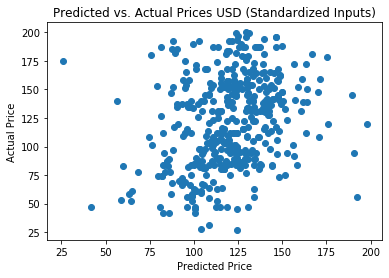

In [22]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD (Standardized Inputs)')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y2_predict, y_test);

In [23]:
print_scores(pipe2, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y2_predict)

Train R2 0.288
Test R2 0.02
RMSError = $39.48


#### Looks like overfitting is taking place. Going to try some regularization.

In [24]:
# Base Lasso 
ls = LassoCV(cv=5, copy_X=True)
ls.fit(X_train, y_train)
ls_y_predict = ls.predict(X_test)
print_scores(ls, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, ls_y_predict)

Train R2 0.196
Test R2 0.088
RMSError = $38.07


In [25]:
test_alphas = np.arange(1, 10, 0.25)
r_squares_train = []
r_squares_test = []
r_diffs = []
for idx, val in enumerate(test_alphas):
    ls_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            Lasso(copy_X=True, max_iter=1000, alpha=val, random_state=42))
    ls_pipe.fit(X_train, y_train)
    ls_pipe_y_predicted = ls.predict(X_test)
    r_squares_train.append(ls_pipe.score(X_train, y_train))
    r_squares_test.append(ls_pipe.score(X_test, y_test))
    r_diffs.append(r_squares_train[idx] - r_squares_test[idx])
min_alpha = test_alphas[np.argmin(np.abs(r_diffs))]

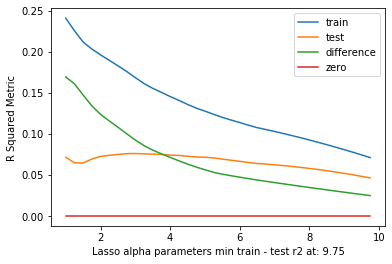

In [26]:
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_diffs)
plt.plot(test_alphas, np.zeros(len(test_alphas)))
plt.legend(['train', 'test', 'difference', 'zero'])
plt.ylabel('R Squared Metric')
plt.xlabel('Lasso alpha parameters min train - test r2 at: {}'.format(min_alpha));

In [27]:
test_alphas = np.arange(900, 1500, 0.25)
r_squares_train = []
r_squares_test = []
for i in test_alphas:
    ls_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            Ridge(copy_X=True, max_iter=1000, alpha=i, random_state=42))
    ls_pipe.fit(X_train, y_train)
    ls_pipe_y_predicted = ls.predict(X_test)
    r_squares_train.append(ls_pipe.score(X_train, y_train))
    r_squares_test.append(ls_pipe.score(X_test, y_test))

In [37]:
test_alphas = np.arange(200, 1500, 25)
r_squares_train = []
r_squares_test = []
r_diffs = []
for idx, val in enumerate(test_alphas):
    ls_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            Ridge(copy_X=True, max_iter=1000, alpha=val, random_state=42))
    ls_pipe.fit(X_train, y_train)
    ls_pipe_y_predicted = ls.predict(X_test)
    r_squares_train.append(ls_pipe.score(X_train, y_train))
    r_squares_test.append(ls_pipe.score(X_test, y_test))
    r_diffs.append(r_squares_train[idx] - r_squares_test[idx])
min_alpha = test_alphas[np.argmin(np.abs(r_diffs))]

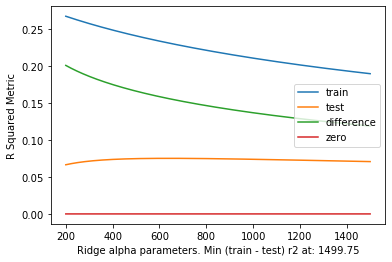

In [39]:
# plt.plot(test_alphas, r_squares_train)
# plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_diffs)
plt.plot(test_alphas, np.zeros(len(test_alphas)))
plt.legend(['train', 'test', 'difference', 'zero'], loc=7)
plt.ylabel('R Squared Metric')
plt.xlabel('Ridge alpha parameters. Min (train - test) r2 at: {}'.format(min_alpha));

In [ ]:
cv_pipe = make_pipeline(StandardScaler(), LinearRegression(normalize=True, n_jobs=100, copy_X=True))
cross_val_score(cv_pipe, X, y, cv=5)

In [ ]:
cross_val_score(LinearRegression(normalize=False, copy_X=True), X, y, cv=5)

In [ ]:
def cvs(x_data, y_data, states, norm=False):
    cvs_lr = LinearRegression(normalize=norm, copy_X=True)
    scores = []
    for state in states:
        cvs_X_train, cvs_X_test, cvs_y_train, cvs_y_test = train_test_split(X, y, shuffle=True, random_state=state)
        cvs_lr.fit(cvs_X_train, cvs_y_train)
        scores.append(((cvs_lr.score(cvs_X_train, cvs_y_train)), cvs_lr.score(cvs_X_test, cvs_y_test)))
    return scores
cvs(X, y, range(0, 500, 100))

In [ ]:
cvs(X, y, range(0, 500, 100), norm=True)